In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta, datetime

efficiency_history_file_path = './dataset/efficiency_history_London_Berlin.json' 

# Write the dictionary to a file in JSON format
with open(efficiency_history_file_path, 'r') as file:
    efficiency_history = json.load(file)
    

In [7]:
from skyfield.api import load
ts = load.timescale()
specific_time = ts.utc(2024, 1, 1, 0, 0, 0)
# Convert specific_time to a datetime object for easier manipulation
# This step assumes specific_time is a single moment; adjust if it's an array
specific_datetime = datetime(year=specific_time.utc.year,
                             month=specific_time.utc.month,
                             day=specific_time.utc.day,
                             hour=specific_time.utc.hour,
                             minute=specific_time.utc.minute,
                             second=int(specific_time.utc.second))


In [8]:
eta_history_np = np.array(efficiency_history)
eta_dB = 10 * np.log10(eta_history_np)
indices = eta_dB > -110
filtered_eta_dB = eta_dB[indices]

# Generate time data for each second
time_data = [specific_datetime + timedelta(seconds=i) for i in range(len(eta_history_np))]
filtered_times = np.array(time_data)[indices]

C:\Users\ycgao\AppData\Local\Temp\ipykernel_2792\1973282527.py:2: RuntimeWarning: divide by zero encountered in log10
  eta_dB = 10 * np.log10(eta_history_np)


E:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


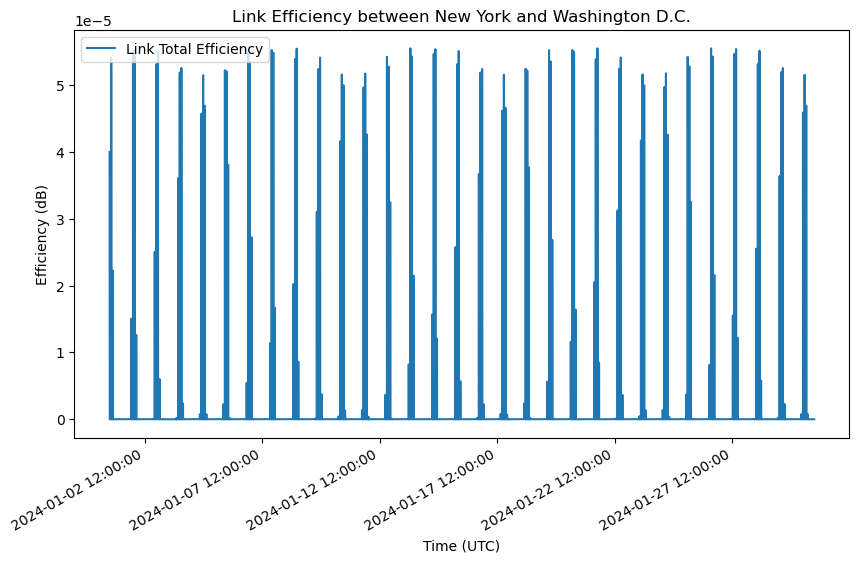

In [9]:
# 绘制效率随时间变化的图
plt.figure(figsize=(10, 6))
plt.plot(time_data,  eta_history_np, label='Link Total Efficiency')

# Formatting the date on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=120))  # Interval every hour
plt.gcf().autofmt_xdate()  # Rotate date labels automatically for better fit


# Setting labels and title
plt.xlabel('Time (UTC)')
plt.ylabel('Efficiency (dB)')
plt.title('Link Efficiency between New York and Washington D.C.')
plt.legend()
plt.grid(False)
plt.show()

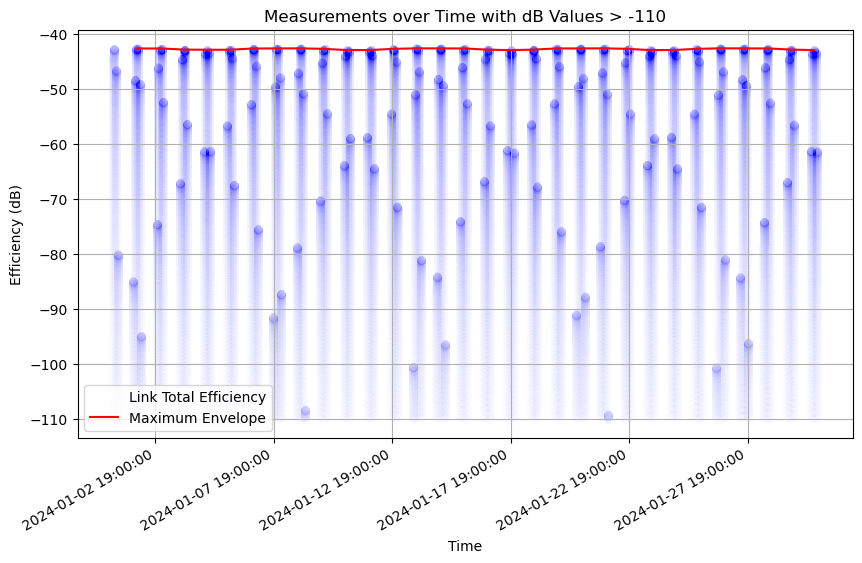

In [10]:
import pandas as pd
plt.figure(figsize=(10, 6))
plt.scatter(filtered_times, filtered_eta_dB, color='blue', alpha=0.005, label='Link Total Efficiency')

# 创建一个 DataFrame 来存储时间和值
df = pd.DataFrame({'Time': filtered_times, 'Efficiency': filtered_eta_dB})

# 舍入到最近的2小时
df['TimeRounded'] = df['Time'].dt.floor('24H')

# 定义一个函数来获取带有最大值和最小值的完整时间戳
def get_max_min_times(group):
    return pd.Series({'MaxTime': group.loc[group['Efficiency'].idxmax(), 'Time'],
                      'MaxValue': group['Efficiency'].max(),
                      'MinTime': group.loc[group['Efficiency'].idxmin(), 'Time'],
                      'MinValue': group['Efficiency'].min()})

# 应用函数并按照时间块重设索引
envelope_df = df.groupby('TimeRounded').apply(get_max_min_times).reset_index()


# 绘制包络线
plt.plot(envelope_df['MaxTime'], envelope_df['MaxValue'], label='Maximum Envelope', color='red')

#plt.plot(envelope_df.index, envelope_df[('Efficiency', 'min')], label='Minimum Envelope', color='green')


# 设置日期格式化
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=120))
plt.gcf().autofmt_xdate()  # 自动旋转日期标签以更好地适应

plt.xlabel('Time')
plt.ylabel('Efficiency (dB)')
plt.title('Measurements over Time with dB Values > -110')
plt.legend()
plt.grid(True)
plt.show()



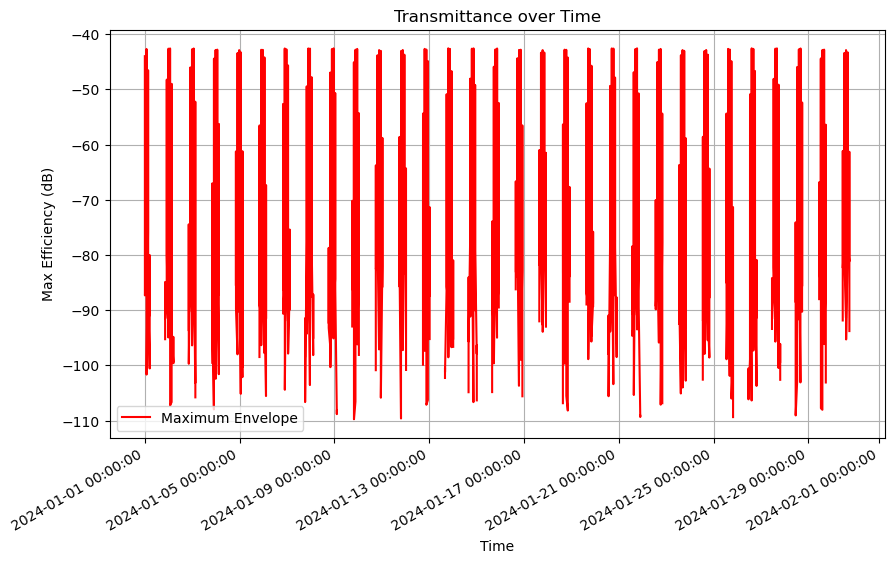

In [11]:
import pandas as pd
# 创建一个 DataFrame 来存储时间和值
df = pd.DataFrame({'Time': filtered_times, 'Efficiency': filtered_eta_dB})

# 现在我们可以按时间对数据进行分组，并找到每个时间点的最大值和最小值
envelope_df = df.groupby(pd.Grouper(key='Time', freq='Min')).agg(['min', 'max'])
envelope_df = envelope_df.dropna()

# 将包络线数据转换成DataFrame，这样更容易操作
envelope_df = envelope_df['Efficiency']['max'].reset_index()
envelope_df.columns = ['Time', 'MaxEfficiency']


# 定义断点的阈值
threshold = pd.Timedelta(hours=2)

# 计算时间差异
envelope_df['Time_diff'] = envelope_df['Time'].diff()

# 找出时间间隔大于阈值的索引
breaks = envelope_df[envelope_df['Time_diff'] > threshold].index

# 分段的起点包括第一个点
start_points = [0] + breaks.tolist()

# 分段的终点包括最后一个点
end_points = breaks.tolist() + [len(envelope_df)]

# 绘图
plt.figure(figsize=(10, 6))

# 绘制所有分段的包络线
for start, end in zip(start_points, end_points):
    segment = envelope_df.iloc[start:end]
    plt.plot(segment['Time'], segment['MaxEfficiency'], color = "red")

# 设置日期格式化
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # 自动确定日期间隔
plt.gcf().autofmt_xdate()  # 优化日期标签的显示

plt.xlabel('Time')
plt.ylabel('Max Efficiency (dB)')
plt.title('Transmittance over Time')
plt.legend(['Maximum Envelope'])
plt.grid(True)
plt.show()

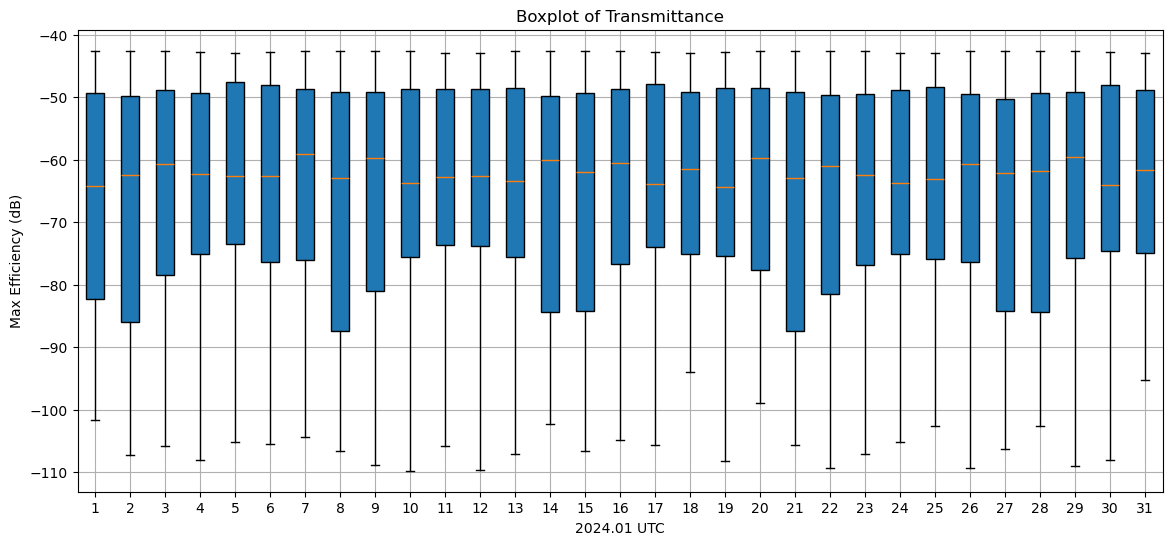

In [12]:
# 分段数据准备
segmented_data = []

for start, end in zip(start_points, end_points):
    segment = envelope_df.iloc[start:end]
    if not segment.empty:
        # 添加分段数据到列表
        segmented_data.append(segment['MaxEfficiency'].tolist())

# 绘制箱线图
plt.figure(figsize=(14, 6))
plt.boxplot(segmented_data, showfliers=True, patch_artist=True)  # 显示异常值，用颜色填充箱体

# 设置箱线图的x轴标签
#plt.xticks(range(1, len(segmented_data) + 1), ['Segment {}'.format(i) for i in range(1, len(segmented_data) + 1)])

plt.xlabel('2024.01 UTC')
plt.ylabel('Max Efficiency (dB)')
plt.title('Boxplot of Transmittance')
plt.grid(True)
plt.show()

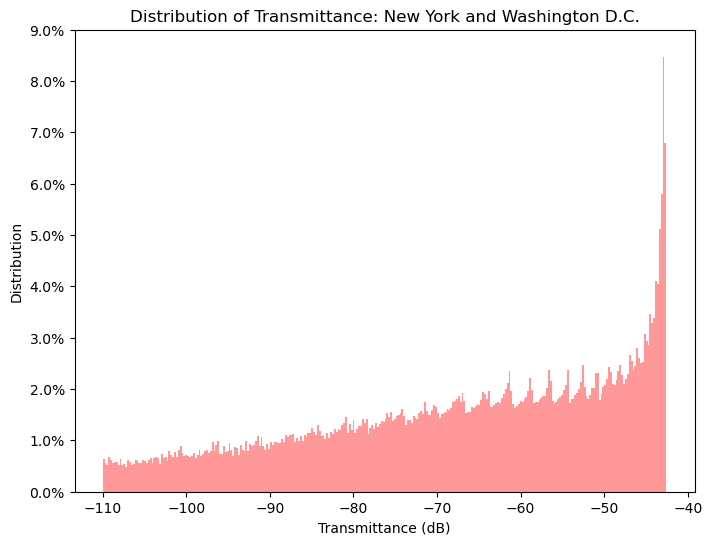

In [13]:
# Step 2: Plotting
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(filtered_eta_dB, bins=300, density=True, alpha=0.4, color='r')  # You can adjust bins for better visualization
# 获取当前y轴的刻度位置和标签
locs, labels = plt.yticks()

# 将概率密度转换为百分比，并设置新的y轴刻度标签
plt.yticks(locs, ['{:,.1%}'.format(x) for x in locs])

plt.xlabel('Transmittance (dB)')
plt.ylabel('Distribution')
plt.title('Distribution of Transmittance: New York and Washington D.C.')
plt.grid(False)
plt.show()